# In this notebook 
We will optimize Adaptive Exponential Integrate and Fire Model and Izhikevich Model 
allen data against some Allen Experimental data.


In [1]:
from neuronunit.allenapi.allen_data_efel_features_opt import opt_setup, opt_setup_two, opt_exec, opt_to_model
from neuronunit.optimization.optimization_management import check_bin_vm15
from neuronunit.optimization.model_parameters import MODEL_PARAMS, BPO_PARAMS, to_bpo_param
from neuronunit.optimization.optimization_management import dtc_to_rheo,inject_and_plot_model
from bluepyopt.allenapi.allen_data_driven import opt_to_model
from utils import dask_map_function
import matplotlib.pyplot as plt
import numpy as np
from neuronunit.optimization.data_transport_container import DataTC
import efel
from jithub.models import model_classes
import matplotlib.pyplot as plt
import quantities as qt
from neuronunit.optimization.optimization_management import inject_model30 # TODO rename, elicit spikes.



ids = [ 324257146,
        325479788,
        476053392,
        623893177,
        623960880,
        482493761,
        471819401
       ]

specimen_id = ids[1]
efel.__file__
efel_list = list(efel.getFeatureNames());
cellmodel = "ADEXP"

/home/user/anaconda3/lib/python3.7/site-packages/cerberus/validator.py:1609: UserWarning: No validation schema is defined for the arguments of rule 'not_zero_obs_zscore'
  "'%s'" % method_name.split('_', 2)[-1]
/home/user/anaconda3/lib/python3.7/site-packages/airspeed/__init__.py:505: FutureWarning: Possible nested set at position 8
  KEYVALSEP = re.compile(r'[ \t]*:[[ \t]*(.*)$', re.S)
test


In [2]:

#cellmodel = "ADEXP";
if cellmodel == "IZHI":
    model = model_classes.IzhiModel()
if cellmodel == "MAT":
    model = model_classes.MATModel()
if cellmodel == "ADEXP":
    model = model_classes.ADEXPModel()



specimen id 623960880 \\
{\small  
\url{http://celltypes.brain-map.org/mouse/experiment/electrophysiology/623960880}
specimen id 623893177 \\
\url{http://celltypes.brain-map.org/mouse/experiment/electrophysiology/623893177}
specimen id 482493761 \\
\url{http://celltypes.brain-map.org/mouse/experiment/electrophysiology/482493761}
specimen id 471819401 \\
\url{http://celltypes.brain-map.org/mouse/experiment/electrophysiology/471819401}


In [3]:
specific_filter_list = ['ISI_log_slope_1.5x',
                        'mean_frequency_1.5x',
                        'adaptation_index2_1.5x',
                        'first_isi_1.5x',
                        'ISI_CV_1.5x',
                        'median_isi_1.5x',
                        'Spikecount_1.5x',
                        'all_ISI_values',
                        'ISI_values',
                        'time_to_first_spike',
                        'time_to_last_spike',
                        'time_to_second_spike',
                        'spike_times',
                        'AHP_depth_abs_1.5x',
                        'peak_voltage_1.5x',
                        'voltage_base_1.5x',
                        'voltage']
simple_yes_list = specific_filter_list
target_num_spikes = 8


In [4]:

def ranged_select_model(model_type):
    dtc = DataTC()
    dtc.backend = model_type
    model = dtc.dtc_to_model()
    dtc.attrs = model._backend.default_attrs
    dtc.params = {k:np.mean(v) for k,v in MODEL_PARAMS[cellmodel].items()}
    model = dtc.dtc_to_model()
    return model


In [5]:
def check_out_model(model):
    dtc = model.model_to_dtc()
    dtc = dtc_to_rheo(dtc)
    vm,plt,dtc = inject_and_plot_model(dtc,plotly=False)
    plt.show()
    print(dtc.attrs)
    print(dtc.rheobase)


Notice the Izhikevich model Needs a lot of computational
resources to optimize. Later we will see that a good fit is possible with a fraction of the resources in the Adexp model, the problem is that the Izhikevich model has a larger number of sensative parameters.

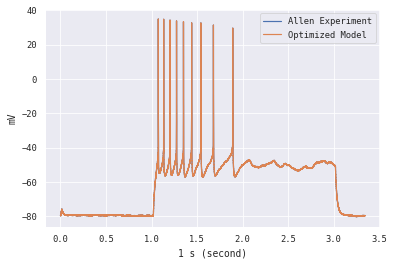

ADEXPModel ADEXP


gen	nevals	avg    	std    	min    	max  
1  	20    	6427.12	8401.66	5.16747	22000


2  	10    	6509.28	8491.21	5.16747	22000
3  	14    	9.41112	5.19245	4.81113	22.2794
4  	16    	858.755	4228.25	4.28255	22000  
5  	14    	6.36724	2.29041	3.12475	13.1673
6  	14    	5.84255	1.26914	3.12475	8.35119
7  	12    	5.03579	1.56836	3.12475	9.04556
8  	14    	4.872  	1.40047	3.11662	7.44601
9  	14    	4.28602	0.800273	3.10799	6.61895
10 	12    	3.62567	0.482022	2.67376	4.56181
11 	12    	3.59269	0.669235	2.20406	5.12806
12 	13    	3.00923	0.435039	2.20406	3.61492
13 	13    	2.86483	0.556796	2.20406	4.29308
14 	13    	2.85699	0.702046	1.52465	4.43585
15 	15    	2.23138	0.498045	1.51799	3.72851
16 	15    	2.26769	0.900868	0.842003	4.65809
17 	10    	2.07622	0.952827	0.842003	6.07998
18 	11    	2.03263	1.05859 	0.842003	5.72929
19 	15    	1.94516	0.623878	0.842003	3.18833
20 	14    	1.85761	0.563812	0.842003	3.03934
21 	15    	1.86988	0.539047	0.842003	2.90896
22 	9     	2.0714 	0.481696	0.842003	2.56295
23 	11    	1.78804	1.33799 	0.842003	7.6597 
24 	13    	1.7161 	0.517608	0.781

In [6]:
from sciunit.scores import ZScore
model = ranged_select_model(cellmodel)
model.params
model.backend
suite, target_current, spk_count, cell_evaluator, simple_cell = opt_setup(specimen_id,
                                                              cellmodel,
                                                              target_num_spikes,
                                                              provided_model=model,
                                                              fixed_current=False)

#cell_evaluator,simple_cell = opt_setup_two(model,cellmodel, suite, nu_tests, target_current, spk_count,provided_model=model,score_type=ZScore)
NGEN = 200
MU = 40

mapping_funct = dask_map_function
final_pop, hall_of_fame, logs, hist = opt_exec(MU,NGEN,mapping_funct,cell_evaluator)

In [7]:

opt,target = opt_to_model(hall_of_fame,cell_evaluator,suite, target_current, spk_count)

In [8]:
best_ind = hall_of_fame[0]
fitnesses = cell_evaluator.evaluate_with_lists(best_ind)
fitnesses;

In [9]:
best_ind

[491.50093874870544,
 -43.69423898242504,
 -94.71676905851228,
 -89.56335313762024,
 37.30878707480102,
 11.546523367862738,
 0.19405194377349697,
 8.970411558261857,
 279.55128408876317,
 -34.60668515749681,
 37.6770118250162]

In [10]:
obnames = [obj.name for obj in cell_evaluator.objectives]

for i,j in zip(fitnesses,obnames):
    print(i,j)

0.04418 burst_mean_freq_1.5x
0.0 burst_number_1.5x
0.02105 single_burst_ratio_1.5x
0.09746 ISI_log_slope_1.5x
0.02768 mean_frequency_1.5x
0.04321 adaptation_index2_1.5x
0.08933 ISI_CV_1.5x
0.0 Spikecount_1.5x
0.04623 all_ISI_values_1.5x
0.03611 ISI_values_1.5x
0.1662 time_to_first_spike_1.5x
0.02847 time_to_last_spike_1.5x
0.01498 time_to_second_spike_1.5x
0.01129 spike_0_1.5x
0.001571 spike_1_1.5x
0.001804 spike_2_1.5x
0.008106 spike_3_1.5x
0.01499 spike_4_1.5x
0.01799 spike_5_1.5x
0.02109 spike_6_1.5x
0.0142 spike_7_1.5x
0.01361 spike_8_1.5x


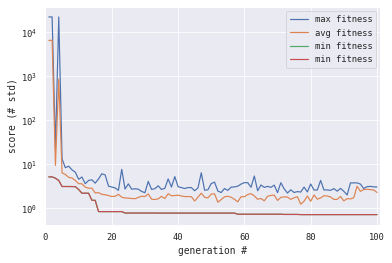

In [11]:


gen_numbers = logs.select('gen')
min_fitness = logs.select('min')
max_fitness = logs.select('max')
avg_fitness = logs.select('avg')
plt.plot(gen_numbers, max_fitness, label='max fitness')
plt.plot(gen_numbers, avg_fitness, label='avg fitness')
plt.plot(gen_numbers, min_fitness, label='min fitness')

plt.plot(gen_numbers, min_fitness, label='min fitness')
plt.semilogy()
plt.xlabel('generation #')
plt.ylabel('score (# std)')
plt.legend()
plt.xlim(min(gen_numbers) - 1, max(gen_numbers) + 1)
plt.show()

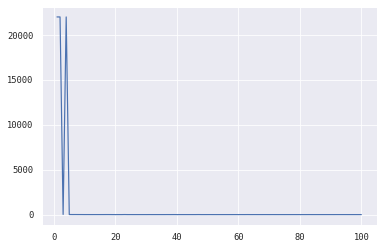

In [12]:
plt.plot(gen_numbers, max_fitness, label='max fitness')
plt.show()

'JIT_ADEXPBackend'

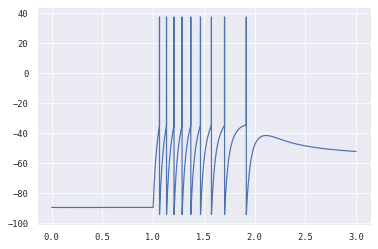

In [13]:


opt.vm15 = None
vm15,_,_,opt=inject_model30(opt,solve_for_current=target_current)
model = opt.dtc_to_model()
plt.plot(opt.vm15.times,opt.vm15)
opt.vm15
model.attrs
model.backend

In [14]:
target_current

{'value': array(533.42529297) * pA}

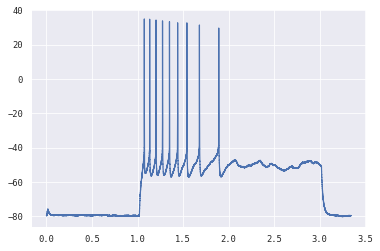

In [15]:
target.vm15 = suite.traces['vm15']

plt.plot(target.vm15.times,target.vm15)
plt.show()


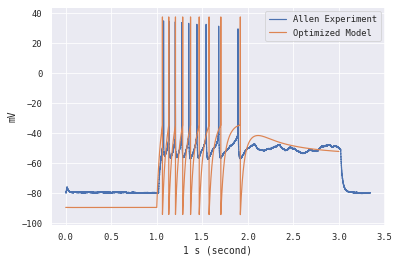

{'cm': 491.50093874870544,
 'v_spike': -43.69423898242504,
 'v_reset': -94.71676905851228,
 'v_rest': -89.56335313762024,
 'tau_m': 37.30878707480102,
 'a': 11.546523367862738,
 'b': 0.19405194377349697,
 'delta_T': 8.970411558261857,
 'tau_w': 279.55128408876317,
 'v_thresh': -34.60668515749681,
 'spike_delta': 37.6770118250162}

In [16]:
target.vm15 = suite.traces['vm15']
check_bin_vm15(target,opt)
opt.attrs

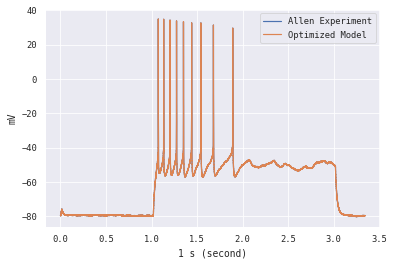

IzhiModel IZHI


gen	nevals	avg    	std    	min    	max  
1  	100   	6186.95	9599.07	11.8161	22000


2  	72    	6596.7 	9840.41	11.8161	22000
3  	72    	1242.11	4748.75	11.8161	22000
4  	62    	1589.85	5526.52	9.65398	22000
5  	64    	739.616	3308.97	9.65398	22000
6  	66    	1416.01	4952.93	9.65398	22000
7  	70    	815.533	3878.62	8.27809	22000
8  	62    	1414.36	5125.85	8.27809	22000
9  	74    	1075.41	4680.56	8.27809	22000
10 	68    	2203.35	6363.16	8.27809	22000
11 	64    	1584.58	5662.24	8.27809	22000
12 	65    	716.672	3854.84	8.27809	22000
13 	74    	1409.49	5219.15	8.27809	22000
14 	71    	1737.59	5819.41	5.88198	22000
15 	66    	702.965	3316.51	5.88198	17013.2
16 	65    	1013.99	3885.81	5.88198	17013.5
17 	66    	1606.52	5445.74	5.50106	22000  
18 	66    	1265.46	4791.64	5.50106	22000  
19 	63    	1524.65	5179.14	5.39175	22000  
20 	72    	1829.05	5855.36	5.37772	22000  
21 	52    	333.414	2455.46	5.04585	22000  
22 	58    	1772.52	5939.12	4.80654	22000  
23 	67    	2567.96	6924.25	4.80654	22000  
24 	61    	684.304	3654.33	4.32264	22000  
25 	63    	2168.83	6371.87	4.32264	22

In [17]:
cellmodel = "IZHI"

model = ranged_select_model(cellmodel)

model.params
model.backend
suite, target_current, spk_count, cell_evaluator, simple_cell = opt_setup(specimen_id,
                                                              cellmodel,
                                                              target_num_spikes,
                                                              provided_model=model,
                                                              fixed_current=False)

NGEN = 100
MU = 100

mapping_funct = dask_map_function
final_pop, hall_of_fame, logs, hist = opt_exec(MU,NGEN,mapping_funct,cell_evaluator)

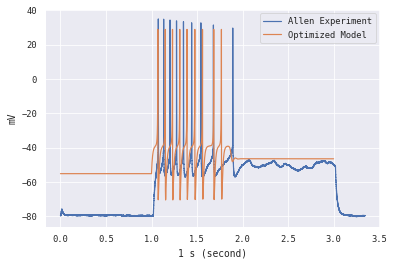

{'C': 27.138814668501944,
 'k': 0.26408668885339215,
 'vr': -55.24621235516244,
 'vt': -47.04439379796771,
 'vPeak': 28.931060650253368,
 'a': 0.1760597259693873,
 'b': 4.395456342171313,
 'c': -54.44893787601643,
 'd': 132.3351561253414,
 'celltype': 3.110010569041976}

In [18]:
opt,target = opt_to_model(hall_of_fame,cell_evaluator,suite, target_current, spk_count)
target.vm15 = suite.traces['vm15']
check_bin_vm15(target,opt)
opt.attrs

# TODO make a nested Genetic Algorithm where the outer loop explores different preferred currents.

This will get rid of the oscillations.